In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import glob
import os
import sklearn.model_selection


In [2]:

metadata = pd.read_csv('metadata.csv')
metadata = metadata[['isic_id','age_approx','clin_size_long_diam_mm','sex','diagnosis_1']]
# encode columns
metadata['sex'] = metadata['sex'].map({'male': 0, 'female': 1})
metadata['diagnosis_1'] = metadata['diagnosis_1'].map({'Benign': 0, 'Malignant': 1})

# missing values
metadata['age_approx'] = metadata['age_approx'].fillna(metadata['age_approx'].mean())
metadata['clin_size_long_diam_mm'] = metadata['clin_size_long_diam_mm'].fillna(metadata['clin_size_long_diam_mm'].mean())
metadata = metadata.dropna()

# Create filename field
metadata['filename'] = metadata['isic_id'].astype(str) + '.jpg'


/var/folders/0b/33n254b510726mq07nrfcfbw0000gn/T/ipykernel_61329/695260491.py:1: DtypeWarning: Columns (6,9,10,11,13,14,15,16,17,18,19,22,23,25,26,27,28,30,35) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv('metadata.csv')


In [3]:
metadata.head()

,isic_id,age_approx,clin_size_long_diam_mm,sex,diagnosis_1,filename
0,ISIC_9536278,45.0,3.988203,1.0,1.0,ISIC_9536278.jpg
1,ISIC_7650956,65.0,3.988203,1.0,1.0,ISIC_7650956.jpg
2,ISIC_5730927,85.0,3.988203,0.0,1.0,ISIC_5730927.jpg
3,ISIC_4305055,85.0,3.988203,1.0,1.0,ISIC_4305055.jpg
4,ISIC_5681611,85.0,3.988203,1.0,1.0,ISIC_5681611.jpg


In [4]:
'''
good_image_paths = []

for path in valid_image_paths:
    try:
        img_raw = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img_raw, channels=3)
        good_image_paths.append(path)
    except:
        print(f"Skipping invalid image: {path}")

with open('good_image_paths.txt', 'w') as f:
    for path in good_image_paths:
        f.write(f"{path}\n")
'''

'\ngood_image_paths = []\n\nfor path in valid_image_paths:\n    try:\n        img_raw = tf.io.read_file(path)\n        img = tf.image.decode_jpeg(img_raw, channels=3)\n        good_image_paths.append(path)\n    except:\n        print(f"Skipping invalid image: {path}")\n\nwith open(\'good_image_paths.txt\', \'w\') as f:\n    for path in good_image_paths:\n        f.write(f"{path}\n")\n'

In [5]:
with open('good_image_paths.txt', 'r') as f:
    image_paths = [line.strip() for line in f]

filenames = [os.path.basename(p) for p in image_paths]
metadata = metadata[metadata['filename'].isin(filenames)].reset_index(drop=True)


In [6]:
# Create lookup dictionaries
label_lookup = dict(zip(metadata['filename'], metadata['diagnosis_1']))
sex_lookup = dict(zip(metadata['filename'], metadata['sex']))
age_lookup = dict(zip(metadata['filename'], metadata['age_approx']))
size_lookup = dict(zip(metadata['filename'], metadata['clin_size_long_diam_mm']))

# Lists for matched data
valid_image_paths = []
labels = []
sex_features = []
age_features = []
size_features = []

for path, fname in zip(image_paths, filenames):
    if fname in label_lookup:
        valid_image_paths.append(path)
        labels.append(label_lookup[fname])
        sex_features.append(sex_lookup[fname])
        age_features.append(age_lookup[fname])
        size_features.append(size_lookup[fname])



In [7]:
trainval_paths, test_paths, trainval_labels, test_labels, \
trainval_sex, test_sex, trainval_age, test_age, trainval_size, test_size = sklearn.model_selection.train_test_split(
    valid_image_paths, labels, sex_features, age_features, size_features,
    test_size=0.1, random_state=42, shuffle=True
)


In [8]:
len(trainval_paths)

436973

In [25]:
from collections import defaultdict
import numpy as np
import shutil
import os

# Group filenames by class
label_to_paths = defaultdict(list)
for path, label in zip(trainval_paths, trainval_labels):
    label_to_paths[label].append(path)

# Sample train set (balanced)
train_paths, train_labels = [], []
for label in [0, 1]:
    paths = label_to_paths[label]
    np.random.seed(42)
    sampled_paths = np.random.choice(paths, 5000, replace=False)
    train_p = sampled_paths[:4000]
    train_paths.extend(train_p)
    train_labels.extend([label] * 4000)

# Sample val set (representative of real-world 96/4 split)
val_paths, val_labels = [], []

np.random.seed(42)
benign_val = np.random.choice(label_to_paths[0], 960, replace=False)
malignant_val = np.random.choice(label_to_paths[1], 40, replace=False)

val_paths.extend(benign_val)
val_labels.extend([0] * 960)
val_paths.extend(malignant_val)
val_labels.extend([1] * 40)


# Create new folders for train/val
for folder in ['images_train_balanced', 'images_val_balanced']:
    os.makedirs(folder, exist_ok=True)

# Copy files into balanced folders
for path in train_paths:
    shutil.copy(path, f'images_train_balanced/{os.path.basename(path)}')

for path in val_paths:
    shutil.copy(path, f'images_val_balanced/{os.path.basename(path)}')


In [26]:

import os
import shutil
os.makedirs('./images_test', exist_ok=True)

for path in test_paths:
    filename = os.path.basename(path)
    shutil.copy(path, f'./images_test/{filename}')


In [11]:


train_image_ds = tf.keras.utils.image_dataset_from_directory(
    directory='images_train_balanced',
    labels=train_labels,
    label_mode='int',
    batch_size=64,
    image_size=(128, 128),
    shuffle=True,
    seed=123
)

val_image_ds = tf.keras.utils.image_dataset_from_directory(
    directory='images_val_balanced',
    labels=val_labels,
    label_mode='int',
    batch_size=64,
    image_size=(128, 128),
    shuffle=True,
    seed=123
)

Found 8000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [12]:
# Test filenames and labels
test_path_to_label = {os.path.basename(p): l for p, l in zip(test_paths, test_labels)}
test_filenames = [os.path.basename(p) for p in test_paths]
test_labels_sorted = [test_path_to_label[fname] for fname in test_filenames]

test_image_ds = tf.keras.utils.image_dataset_from_directory(
    directory='./images_test',
    labels=test_labels_sorted,
    label_mode='int',
    batch_size=64,
    image_size=(128, 128),
    shuffle=False
)


Found 48553 files belonging to 2 classes.


In [13]:
train_metadata_ds = tf.data.Dataset.from_tensor_slices(
    tf.stack([trainval_sex[:len(train_image_ds)], trainval_age[:len(train_image_ds)], trainval_size[:len(train_image_ds)]], axis=1)
)

val_metadata_ds = tf.data.Dataset.from_tensor_slices(
    tf.stack([trainval_sex[len(train_image_ds):], trainval_age[len(train_image_ds):], trainval_size[len(train_image_ds):]], axis=1)
)

test_metadata_ds = tf.data.Dataset.from_tensor_slices(
    tf.stack([test_sex, test_age, test_size], axis=1)
)


In [14]:
train_images_only_ds = train_image_ds.map(lambda x, y: x)
train_labels_only_ds = train_image_ds.map(lambda x, y: y)

train_inputs_ds = tf.data.Dataset.zip((train_images_only_ds, train_metadata_ds))
final_train_ds = tf.data.Dataset.zip((train_inputs_ds, train_labels_only_ds)).prefetch(tf.data.AUTOTUNE)

val_images_only_ds = val_image_ds.map(lambda x, y: x)
val_labels_only_ds = val_image_ds.map(lambda x, y: y)

val_inputs_ds = tf.data.Dataset.zip((val_images_only_ds, val_metadata_ds))
final_val_ds = tf.data.Dataset.zip((val_inputs_ds, val_labels_only_ds)).prefetch(tf.data.AUTOTUNE)

test_images_only_ds = test_image_ds.map(lambda x, y: x)
test_labels_only_ds = test_image_ds.map(lambda x, y: y)

test_inputs_ds = tf.data.Dataset.zip((test_images_only_ds, test_metadata_ds))
final_test_ds = tf.data.Dataset.zip((test_inputs_ds, test_labels_only_ds)).prefetch(tf.data.AUTOTUNE)




In [15]:

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Load the base model
base_model = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze base model

# Add custom classification head
inputs = Input(shape=(128, 128, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)  # Binary classification
model = Model(inputs, outputs)

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train top layers first
history = model.fit(train_image_ds,
                    validation_data=val_image_ds,
                    epochs=20,
                    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)])

# Unfreeze and fine-tune
base_model.trainable = True
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Fine-tune the whole model
history_finetune = model.fit(train_image_ds,
                             validation_data=val_image_ds,
                             epochs=50,
                             callbacks=[EarlyStopping(patience=8, restore_best_weights=True)])


Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 22s 163ms/step - accuracy: 0.7569 - loss: 0.4896 - val_accuracy: 0.1920 - val_loss: 1.7582
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 158ms/step - accuracy: 0.8222 - loss: 0.4036 - val_accuracy: 0.1660 - val_loss: 1.9126
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 162ms/step - accuracy: 0.8328 - loss: 0.3897 - val_accuracy: 0.1510 - val_loss: 2.2625
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 162ms/step - accuracy: 0.8346 - loss: 0.3834 - val_accuracy: 0.2410 - val_loss: 1.2330
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 165ms/step - accuracy: 0.8417 - loss: 0.3715 - val_accuracy: 0.1970 - val_loss: 1.6063
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 167ms/step - accuracy: 0.8507 - loss: 0.3606 - val_accuracy: 0.1890 - val_loss: 1.7065
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 162ms/step - accuracy: 0.8530 - loss: 0.3585 - val_accuracy: 0.2080 - val_loss: 1.6405
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 160ms/step - accuracy: 0.8548 - loss: 0

In [16]:
test_loss, test_accuracy = model.evaluate(test_image_ds)
print(f"Test accuracy: {test_accuracy:.4f}")

759/759 ━━━━━━━━━━━━━━━━━━━━ 98s 128ms/step - accuracy: 0.3686 - loss: 1.5480
Test accuracy: 0.2591


In [17]:
y_pred_probs = model.predict(test_image_ds)
y_pred = np.round(y_pred_probs).astype(int)

759/759 ━━━━━━━━━━━━━━━━━━━━ 99s 130ms/step


In [18]:
y_true = np.array(test_labels_sorted)

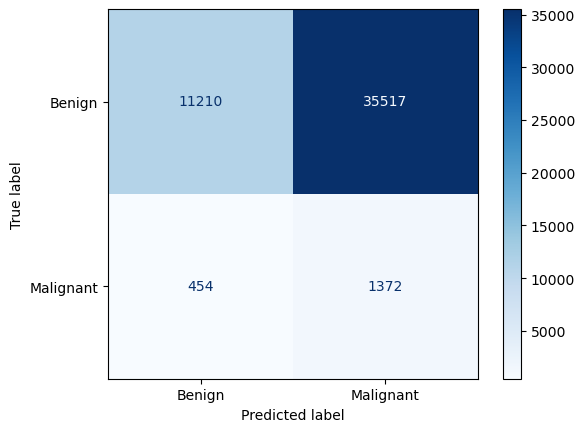

In [19]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Malignant'])
disp.plot(cmap='Blues',values_format='d')


In [20]:
print(classification_report(y_true, y_pred, target_names=['Benign', 'Malignant']))

              precision    recall  f1-score   support

      Benign       0.96      0.24      0.38     46727
   Malignant       0.04      0.75      0.07      1826

    accuracy                           0.26     48553
   macro avg       0.50      0.50      0.23     48553
weighted avg       0.93      0.26      0.37     48553



2025-05-12 16:39:51.369842: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


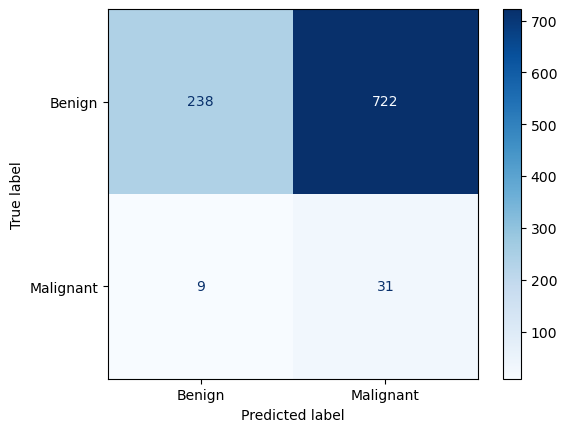

In [21]:
import matplotlib.pyplot as plt
y_true = []
y_pred = []

# Loop through the shuffled dataset in the same order used for prediction
for images, labels in val_image_ds:
    preds = model.predict(images, verbose=0)
    y_pred.extend(np.round(preds).astype(int).flatten())  # or np.argmax if softmax
    y_true.extend(labels.numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Malignant'])
disp.plot(cmap='Blues', values_format='d')
plt.show()

In [22]:
test_loss, test_accuracy = model.evaluate(val_image_ds)

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.2517 - loss: 1.7002


In [23]:
model.save('model_5000.keras')

In [27]:
import numpy as np

# Get predictions and true labels from val_image_ds
y_probs = []
y_true = []

for images, labels in val_image_ds:
    preds = model.predict(images, verbose=0).flatten()  # shape (batch_size,)
    y_probs.extend(preds)
    y_true.extend(labels.numpy())

y_probs = np.array(y_probs)
y_true = np.array(y_true)


In [28]:
from sklearn.metrics import f1_score

thresholds = np.linspace(0, 1, 100)
f1_scores = []

for thresh in thresholds:
    y_pred = (y_probs > thresh).astype(int)
    f1_scores.append(f1_score(y_true, y_pred))

best_thresh = thresholds[np.argmax(f1_scores)]
print(f"Best threshold: {best_thresh:.2f}, F1-score: {max(f1_scores):.4f}")


Best threshold: 0.88, F1-score: 0.1050


In [30]:
y_pred_probs = model.predict(test_image_ds)
y_test_pred = (y_pred_probs > best_thresh).astype(int)


759/759 ━━━━━━━━━━━━━━━━━━━━ 100s 131ms/step


In [31]:
y_true = np.array(test_labels_sorted)

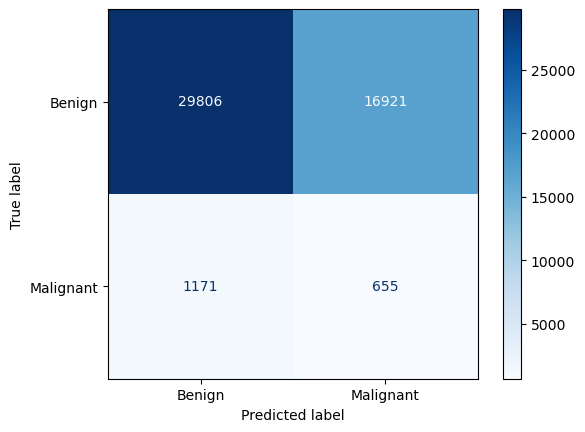

In [35]:
cm = confusion_matrix(y_true, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Malignant'])
disp.plot(cmap='Blues',values_format='d')